In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [ ]:
import os 

import pandas_datareader as pdr
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import seaborn as sns
import jax.numpy as jnp
from jax import random
import numpy as np
import statsmodels.api as sm


import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(4)
assert numpyro.__version__.startswith("0.10.0")

plt.style.use('seaborn')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the data

In [ ]:
!pip3 install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
os.chdir('/content/drive/MyDrive/cwp_data')

In [ ]:
with open('eu.pickle','rb') as fn:
  EU_Milk = pickle.load(fn)

with open('us.pickle','rb') as fn:
  US_Milk = pickle.load(fn)

with open('cn.pickle','rb') as fn:
  CN_Milk = pickle.load(fn)
CN_Milk.name = 'China'

with open('fred.pickle','rb') as fn:
  commodity_economic_ind = pickle.load(fn)

In [ ]:
'''from datetime import datetime as dt
start = dt(1980,1,1)
end = dt(2022,6,1)

EU_Milk = pd.read_excel('https://www.clal.it/upload/eu-milk-historical-price-series_en06072022.xlsx', usecols='B:AC,AE', header=6, index_col=28, nrows=546)
us_raw = pd.read_html('https://quickstats.nass.usda.gov/data/printable/ED3AE74E-9CE1-3094-BA0D-CD94A67BC399')[0][['Year','Period','State','Value']]
us_raw['Date'] = pd.to_datetime(us_raw.Period + '-' + us_raw.Year.astype(str))
US_Milk = us_raw.pivot(index='Date', columns='State').Value.rename(columns=str.title)
china_raw = pd.read_html('https://www.clal.it/en/index.php?section=latte_cina')[9].iloc[2:14,0::2].iloc[:,:-2].to_numpy(dtype=float).T.flatten()
china_raw = china_raw[~np.isnan(china_raw)]
print(type(china_raw))
China_Milk = pd.Series(china_raw, index = pd.date_range('2009-1-1', '2022-6-1',  freq='MS'), name='China')
commodity_economic_ind = pdr.get_data_fred(['MCOILBRENTEU', 'MCOILWTICO', 'MHHNGSP', 'PBARLUSDM', 'PMAIZMTUSDM', 'PNGASEUUSDM', 'PSOYBUSDM', 'PWHEAMTUSDM', 'IPG32411S', 'A33DNO', 'PCEC96' ], start, end)'''

"from datetime import datetime as dt\nstart = dt(1980,1,1)\nend = dt(2022,6,1)\n\nEU_Milk = pd.read_excel('https://www.clal.it/upload/eu-milk-historical-price-series_en06072022.xlsx', usecols='B:AC,AE', header=6, index_col=28, nrows=546)\nus_raw = pd.read_html('https://quickstats.nass.usda.gov/data/printable/ED3AE74E-9CE1-3094-BA0D-CD94A67BC399')[0][['Year','Period','State','Value']]\nus_raw['Date'] = pd.to_datetime(us_raw.Period + '-' + us_raw.Year.astype(str))\nUS_Milk = us_raw.pivot(index='Date', columns='State').Value.rename(columns=str.title)\nchina_raw = pd.read_html('https://www.clal.it/en/index.php?section=latte_cina')[9].iloc[2:14,0::2].iloc[:,:-2].to_numpy(dtype=float).T.flatten()\nchina_raw = china_raw[~np.isnan(china_raw)]\nprint(type(china_raw))\nChina_Milk = pd.Series(china_raw, index = pd.date_range('2009-1-1', '2022-6-1',  freq='MS'), name='China')\ncommodity_economic_ind = pdr.get_data_fred(['MCOILBRENTEU', 'MCOILWTICO', 'MHHNGSP', 'PBARLUSDM', 'PMAIZMTUSDM', 'PNGASEUU

In [ ]:
economic_indicators = ['IPG32411S', 'A33DNO', 'PCEC96']

In [ ]:
combined_data = commodity_economic_ind.join(US_Milk['US Total']).dropna()\
                    .join(EU_Milk['EU(without UK)']).dropna()\
                    .join(CN_Milk)

## Model 

The Seasonal, Global Trend model 




In [ ]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

Define MCMC sampler using the NUTS algorithm

In [ ]:
%%time
# No-U-Turn Sampler
def mcmc_sampler(data, n_warmup, n_samples, 
                 n_chains, s, model=sgt):
  kernel = NUTS(model)
  mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains)
  mcmc.run(random.PRNGKey(0), data, seasonality=s)
  mcmc.print_summary()
  samples = mcmc.get_samples()
  return samples

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


### Plot Forecast

In [ ]:
def plot_forecast(data, data_train, data_test, samples, seasonality=None):
    
    predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
    forecast_marginal = predictive(random.PRNGKey(1), data_train, seasonality=seasonality, future=len(data_test))[
        "y_forecast"
    ]
    data_pred = jnp.mean(forecast_marginal, axis=0)
    sMAPE = jnp.mean(jnp.abs(data_pred - data_test) / (data_pred + data_test)) * 200
    msqrt = jnp.sqrt(jnp.mean((data_pred - data_test) ** 2))
    
    print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))
    print(f'Seasonality: {seasonality}')
    forecast_length = len(data_train)
    plt.figure(figsize=(8, 4))
    plt.plot(data.index, data, label = f"{data.name} data")
    t_future = data.index[forecast_length:]
    hpd_low, hpd_high = hpdi(forecast_marginal)
    plt.plot(t_future, data_pred, lw=2, label = 'prediction')
    plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3, label = '90% HDPI')
    plt.title(f"Forecasting {data.name} dataset with SGT model (90% HPDI)")
    plt.legend()
    plt.show()

## Modelling US milk price

lenght of time series is 509


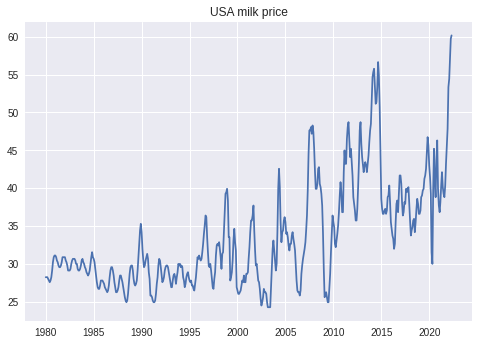

In [ ]:
plt.plot(US_Milk['US Total'])
print(f"lenght of time series is {US_Milk['US Total'].shape[0]}")
plt.title('USA milk price')

plt.show()

Looking at the plot above, we can observe seasonality in the series as there is the recurrence of similar patterns over specific time periods -- there is an obvious cyclical trend occuring every five years with some clear spikes occuring somewhere around year 2007, 2013, 2015, and 2021. 

Since there is a sign of seasonality, the Seasonal global trend model will be employed for this analysis.

In [ ]:
# dataset is approximately split using the 80/20 heuristic

data_us = US_Milk['US Total'].dropna()
us_split = int(len(data_us)*0.80)
us_train, us_test = jnp.array(data_us[:us_split], dtype=jnp.float32),jnp.array(data_us[us_split:], dtype=jnp.float32)

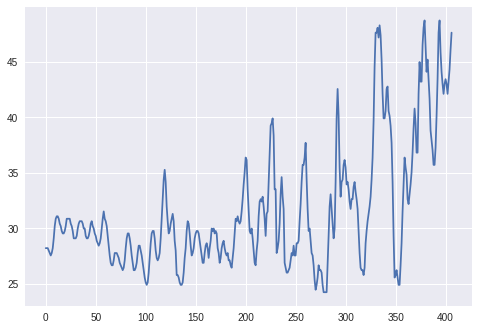

In [ ]:
plt.plot(us_train)

In [ ]:
print("Lag values sorted according to their autocorrelation values:\n")
lag_val_us = jnp.argsort(autocorrelation(us_train)[::-1])
print(lag_val_us)

Lag values sorted according to their autocorrelation values:

[  0   1   2   3   5   6   4   7   8   9  10  11  12  13  14  15  16  17
  18  30  31  29  32  78  77  79  19  28  33  76  80 102 103 101  27  34
  75  20 100 104  81 114  99 105 113  74  35 112 115  26  82 111 106  98
  36  21 110  73 107  37 109 108 116  90  91  97  83  38  25  89  92  39
  40  72  41  88  96  22  93  42  24  84  95  94  87  23  71  85  86 117
  43  68  70  67  69  66  44 118  65  45 138  46 139 137  64 119  47 140
 136  52  51  48  53  50  49 124 162 141 163 123  54 125 161 120 122 164
 121 174 126 135 173 142 160 172  63  55 175 171 148 165 149 170 147 143
 176 169 146 127 150 144 166 159 145 168 167 134  56  62 177 151 128 158
 133 152 178 129  57  61 157 132 130 153 179 131  60 156  58 180 184 154
 185 183  59 155 181 182 186 187 210 209 208 211 188 207 212 206 189 197
 281 198 196 280 199 195 282 213 205 279 194 190 200 193 204 191 192 214
 201 283 278 203 202 215 216 217 284 246 245 218 277 247 219 2

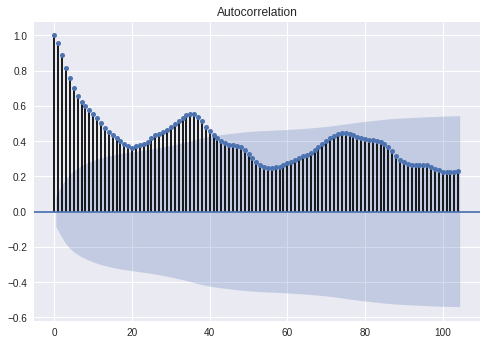

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(data_us, lags=104)
plt.show()

In [ ]:
us_samples = mcmc_sampler(us_train, 5000, 5000, 4, 104)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.20      0.35      0.13     -0.26      0.74   5195.74      1.00
       init_s[0]      0.45      1.88      0.39     -2.67      3.50   3598.39      1.00
       init_s[1]     -0.83      1.45     -0.89     -3.14      1.56   3022.90      1.00
       init_s[2]     -1.30      1.48     -1.36     -3.74      1.09   9604.97      1.00
       init_s[3]     -1.30      1.50     -1.34     -3.68      1.14   4051.37      1.00
       init_s[4]     -1.18      1.52     -1.20     -3.64      1.30   4623.54      1.00
       init_s[5]     -0.90      1.52     -0.94     -3.40      1.63   7897.13      1.00
       init_s[6]     -0.90      1.56     -0.93     -3.43      1.61   5030.13      1.00
       init_s[7]     -0.90      1.62     -0.94     -3.51      1.78   1318.61      1.00
       init_s[8]     -0.45      1.51     -0.48     -2.84      2.12  11861.17      1.00
       init_s[9]      0.16      1.54      

### Forecasting USA milk price

sMAPE: 17.58, rmse: 8.81
Seasonality: 104


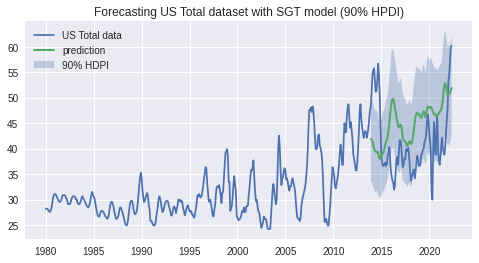

In [ ]:
plot_forecast(data_us, us_train, us_test, us_samples, seasonality=104)

## Modelling Germany milk price

length of time series is 366


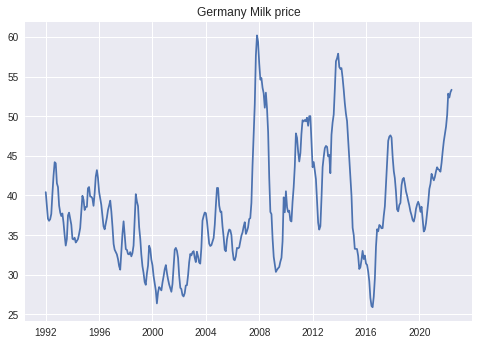

In [ ]:
germany = EU_Milk['Germany'].dropna()
plt.plot(germany)
plt.title('Germany Milk price')
print(f'length of time series is {germany.shape[0]}')
plt.show()

In [ ]:
# data split using 80/20 heuristic
split = int(len(germany)*0.80)
ger_train, ger_test = jnp.array(germany.values[:split], dtype=jnp.float32),jnp.array(germany.values[split:], dtype=jnp.float32)

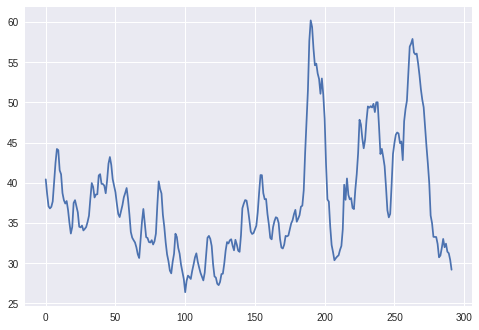

In [ ]:
plt.plot(ger_train)
plt.show()

In [ ]:
print("Lag values sorted according to their autocorrelation values:\n")
lag_val_ger = jnp.argsort(autocorrelation(ger_train))[::-1]
lag_val_ger

Lag values sorted according to their autocorrelation values:



DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  36,  37,
              35,  38,  34,  10,  39,  33,  11,  40, 260,  32,  41, 261,
             259, 262, 258,  12,  42,  31, 263, 257,  43, 256,  72, 264,
              30, 255,  73,  44,  13,  71, 223, 222, 224, 254,  29,  74,
             221, 225,  45, 219, 218, 220,  70, 217, 265,  28, 226,  27,
             216,  46,  75, 253, 227,  26,  14,  69,  25, 215, 228,  47,
             266,  76,  24, 252,  68,  15, 214,  48, 229,  23,  77,  67,
             267,  16, 251,  22, 213,  49, 230,  78,  66, 185, 184, 186,
             187, 188, 183, 189, 190,  17,  21, 182, 212, 191,  65, 268,
              18,  20, 181,  64,  79,  50,  19,  63,  62, 250, 192, 211,
             231,  61, 180, 269, 287,  80, 286,  60,  51, 193, 270, 210,
             271, 179, 249,  81, 288, 272,  59, 232, 209, 285,  52, 194,
              58, 273,  82, 208, 248, 178,  53, 233,  57, 207, 289, 195,
              54, 206, 205,  83,  56,  55, 274, 204

In [ ]:
%%time
ger_samples = mcmc_sampler(ger_train, 5000, 5000, 4, 260)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
plot_forecast(germany, ger_train, ger_test, ger_samples, seasonality=260)

## Modeling China Milk price

length of time series is 162


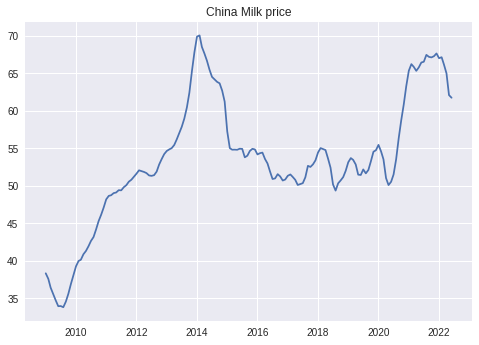

In [ ]:
plt.plot(CN_Milk)
print(f"length of time series is {CN_Milk.shape[0]}")
plt.title('China Milk price')
plt.show()

In [ ]:
# dataset is approximately split using the 80/20 heuristic

data_cn = CN_Milk
cn_split = int(len(data_cn)*0.80)
cn_train, cn_test = jnp.array(data_cn.values[:cn_split], dtype=jnp.float32),jnp.array(data_cn.values[cn_split:], dtype=jnp.float32)

In [ ]:
print("Lag values sorted according to their autocorrelation values:\n")
lag_val_cn = jnp.argsort(autocorrelation(cn_train))[::-1]
lag_val_cn

Lag values sorted according to their autocorrelation values:



DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  89,  88,  90,  87,  91,  86,  92,
              29,  93,  85,  94, 113, 114, 124,  84,  95, 112,  30, 125,
              96, 127,  83,  97, 115, 111,  31, 123,  82, 126,  98,  81,
             110,  32,  99, 128,  80, 116,  33,  79, 122, 100, 109,  78,
              34, 117,  77, 101,  76, 108,  75,  35,  74, 121, 118,  73,
             102, 107,  36, 119,  72, 120, 106, 103, 105, 104,  37,  71,
              38,  70,  39,  40,  69,  41,  68,  42,  67,  43,  66,  44,
              45,  65,  46,  64,  47,  63,  48,  49,  62,  50,  61,  51,
              60,  52,  59,  53,  58,  54,  57,  55,  56], dtype=int32)

In [ ]:
%%time
cn_samples = mcmc_sampler(cn_train, 5000, 5000, 4, 89)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.37      0.41      0.26     -0.14      0.99   5195.44      1.00
       init_s[0]     -4.52      3.55     -4.52    -10.41      1.20   2255.67      1.00
       init_s[1]     -0.62      0.61     -0.64     -1.65      0.36  13368.07      1.00
       init_s[2]     -0.90      0.67     -0.91     -2.01      0.17  12137.18      1.00
       init_s[3]     -0.83      0.65     -0.81     -1.92      0.20  11114.24      1.00
       init_s[4]     -1.26      0.61     -1.25     -2.26     -0.27   8806.13      1.00
       init_s[5]     -1.90      0.59     -1.90     -2.88     -0.96  17612.68      1.00
       init_s[6]     -1.89      0.59     -1.88     -2.86     -0.96   9894.40      1.00
       init_s[7]     -2.12      0.62     -2.09     -3.18     -1.15  12097.05      1.00
       init_s[8]     -2.02      0.67     -1.97     -3.12     -0.93  10443.41      1.00
       init_s[9]     -2.25      0.74     -

### forecasting China milk price

sMAPE: 7.85, rmse: 5.44
Seasonality: 89


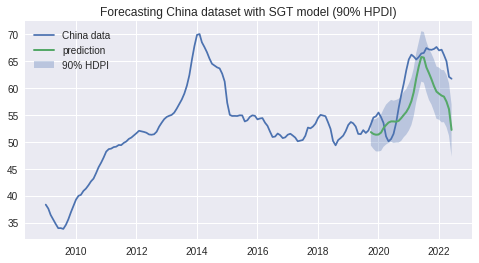

In [ ]:
plot_forecast(data_cn, cn_train, cn_test, cn_samples, seasonality=89)

# Regression relationship betweeen milk prices and energy prices

In [ ]:
commodity_vars = list(combined_data.iloc[:, :-3].columns)

In [ ]:
germany=EU_Milk.loc[:, 'Germany']
combined_data['Germany'] = germany

In [ ]:
combined_data

,MCOILBRENTEU,MCOILWTICO,MHHNGSP,PBARLUSDM,PMAIZMTUSDM,PNGASEUUSDM,PSOYBUSDM,PWHEAMTUSDM,IPG32411S,A33DNO,PCEC96,Us Total,EU\n\n(without UK),China,Germany
DATE,,,,,,,,,,,,,,,
2013-07-01,107.93,104.67,3.62,213.456045,279.013271,10.980000,548.349617,257.472893,96.2436,2576.0,11195.4,19.1,36.423269,355.0,37.56
2013-08-01,111.28,106.57,3.43,187.159745,234.938766,10.970000,498.048327,258.925938,95.7353,2904.0,11207.9,19.6,36.939275,361.0,37.70
2013-09-01,111.60,106.29,3.62,168.809160,207.490173,10.960000,503.237122,257.499616,96.9403,2568.0,11239.9,20.1,38.489144,370.0,40.00
2013-10-01,109.08,100.54,3.68,153.687380,201.779993,10.930000,472.827517,278.149557,96.8073,3168.0,11271.4,20.9,39.499446,381.0,41.74
2013-11-01,107.79,93.86,3.64,149.014066,199.182444,10.960000,476.662241,259.777723,96.1106,2076.0,11318.7,21.6,40.226750,398.0,42.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,75.17,72.49,3.84,180.169083,278.445756,12.544717,523.571480,243.628007,89.1262,1541.0,13653.8,17.8,35.990000,431.0,36.55
2021-08-01,70.75,67.73,4.07,169.775842,257.020755,15.323414,504.040056,274.876030,88.9305,1369.0,13753.5,17.6,36.410000,437.0,36.55
2021-09-01,74.49,71.65,5.16,175.574479,235.815604,22.091544,469.440136,269.733507,88.8323,1336.0,13789.9,18.3,37.290000,434.0,37.51


In [ ]:
targets = combined_data.drop(commodity_economic_ind.columns, axis =1)

In [ ]:
targets

,Us Total,EU\n\n(without UK),China,Germany
DATE,,,,
2013-07-01,19.1,36.423269,355.0,37.56
2013-08-01,19.6,36.939275,361.0,37.70
2013-09-01,20.1,38.489144,370.0,40.00
2013-10-01,20.9,39.499446,381.0,41.74
2013-11-01,21.6,40.226750,398.0,42.46
...,...,...,...,...
2021-07-01,17.8,35.990000,431.0,36.55
2021-08-01,17.6,36.410000,437.0,36.55
2021-09-01,18.3,37.290000,434.0,37.51


## Visualizing the linear relationships between all energy variables and each Milk price variable

Before we begin this analysis, we need to observe the linear relationship(s) between the energy variables and milk price variables.

### For USA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


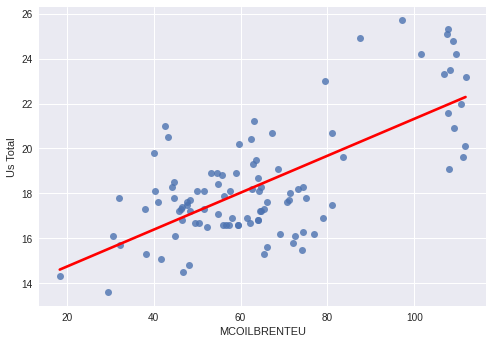

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


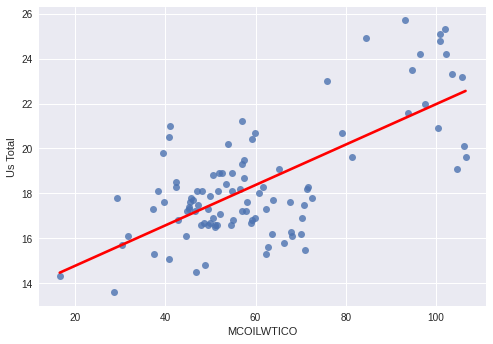

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


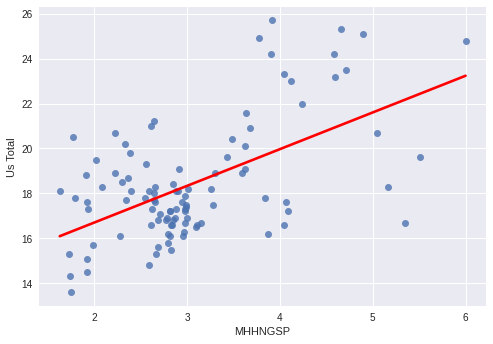

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


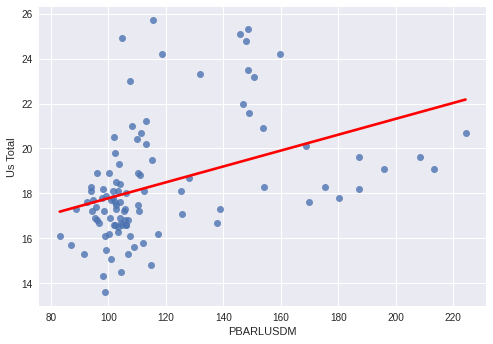

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


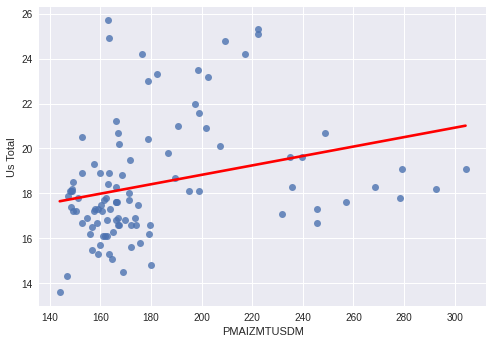

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


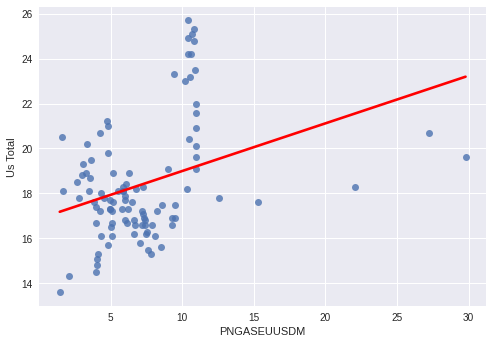

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


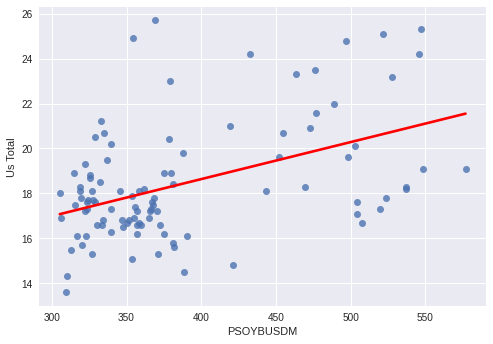

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


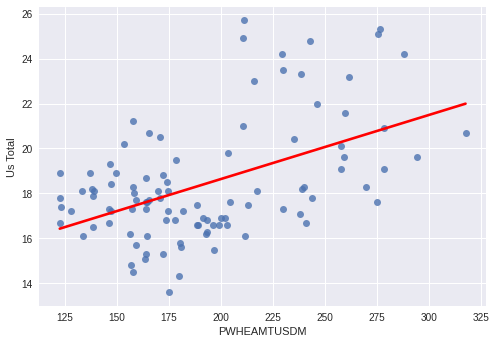

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


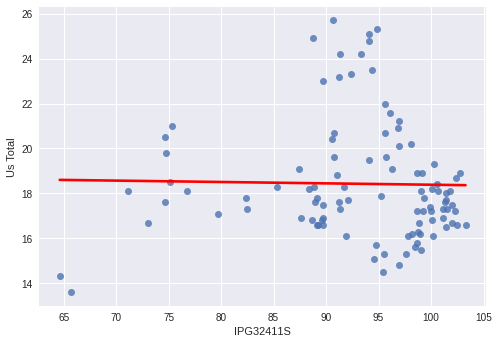

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


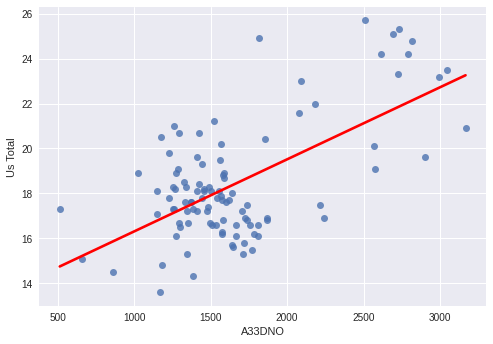

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


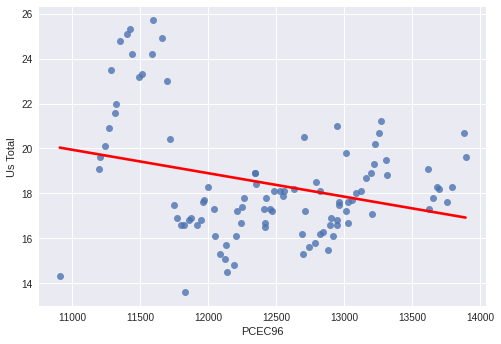

In [ ]:
for i, j in combined_data[commodity_vars].iteritems():
    sns.regplot(j, targets.iloc[:, 0], ci=None, line_kws={"color": "red"})
    plt.show()

### For EU 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


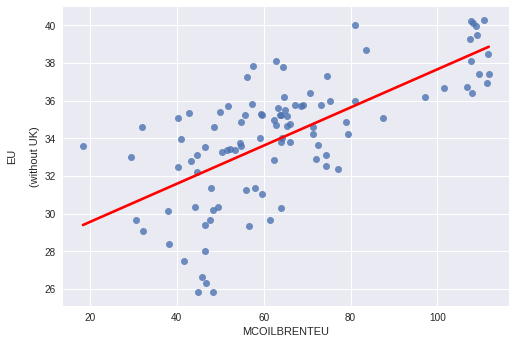

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


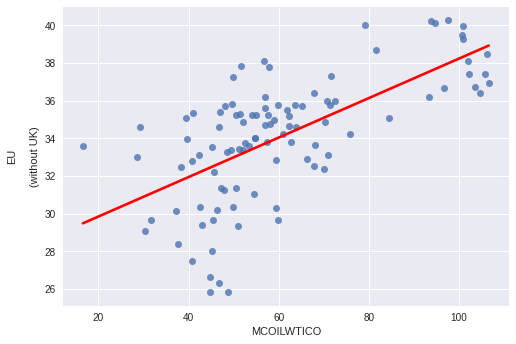

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


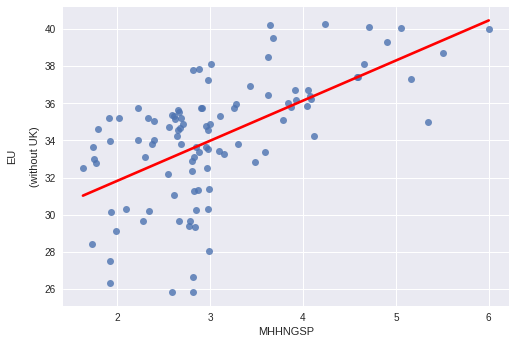

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


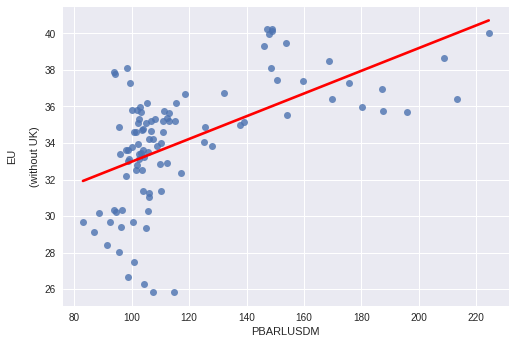

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


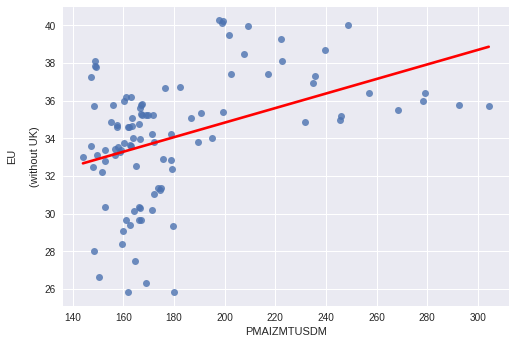

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


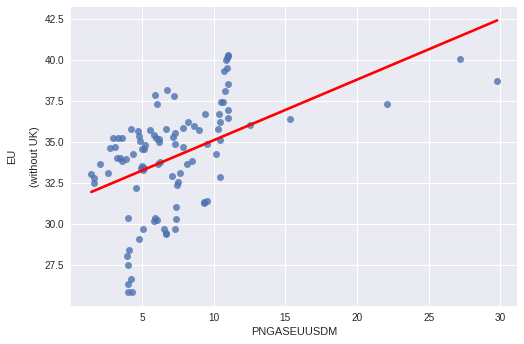

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


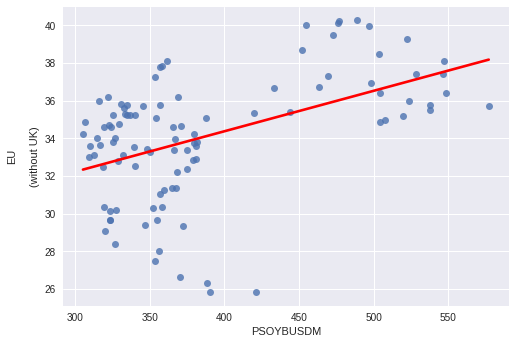

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


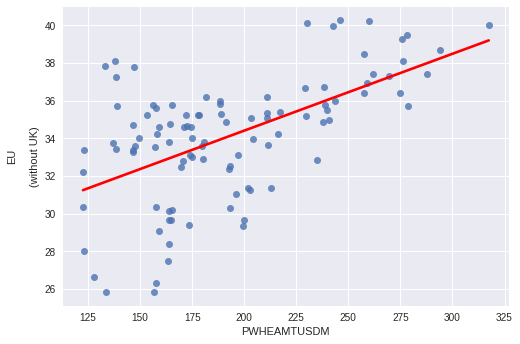

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


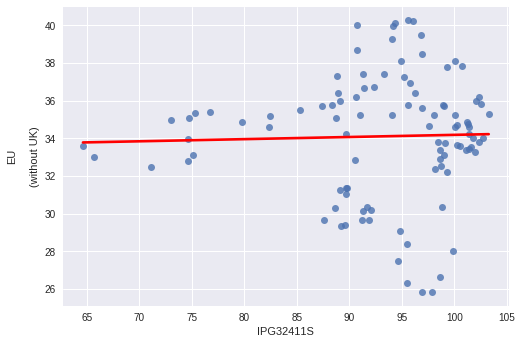

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


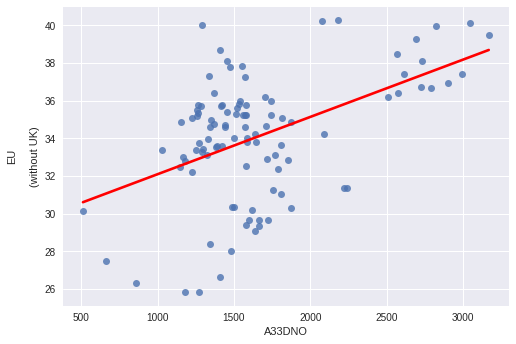

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


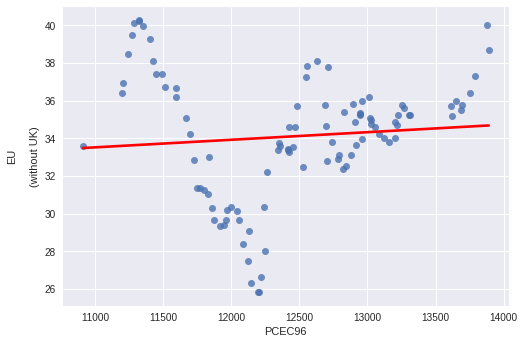

In [ ]:
for i,j in combined_data[commodity_vars].iteritems():
    sns.regplot(j, targets.iloc[:, 1],  ci=None, line_kws={"color": "red"})
    plt.show()

### For China

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


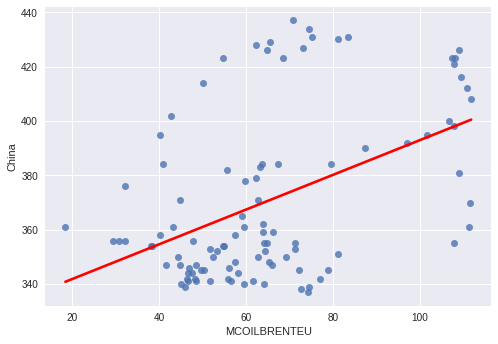

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


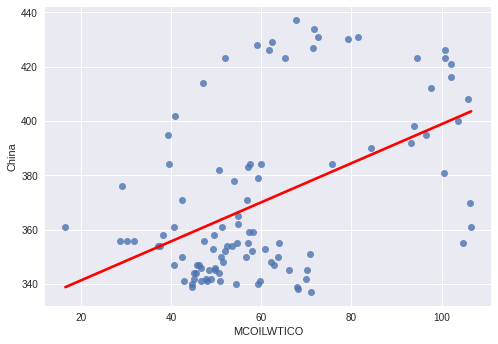

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


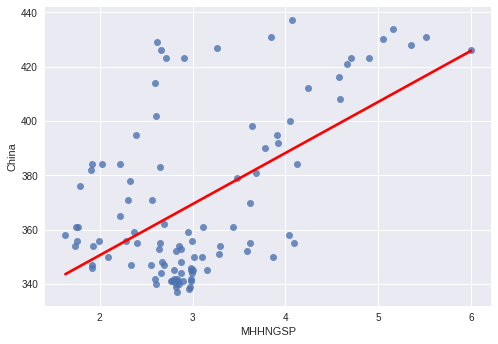

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


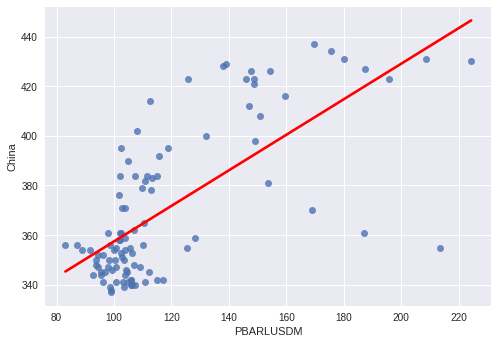

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


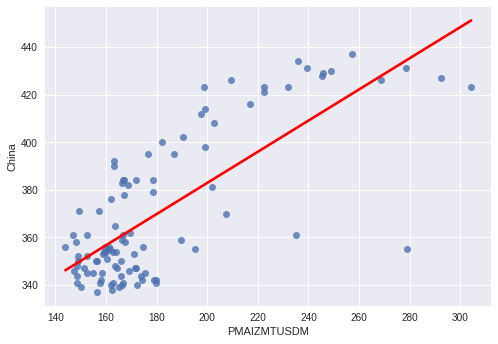

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


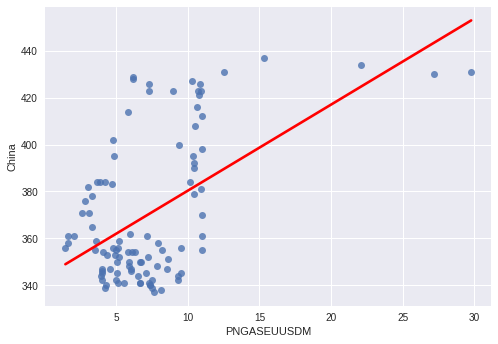

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


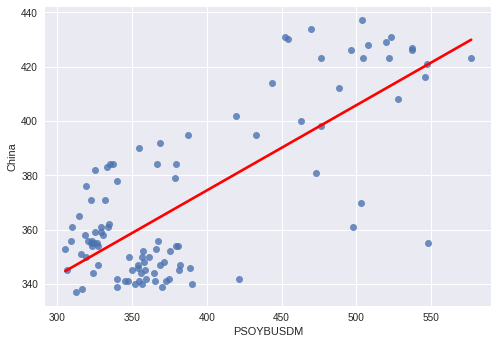

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


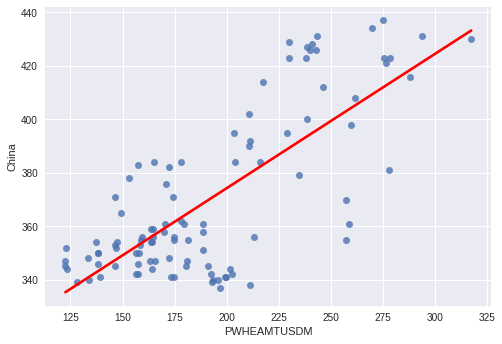

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


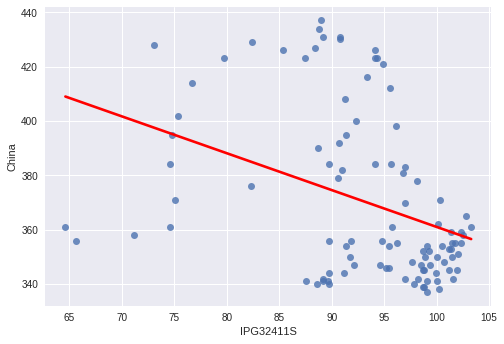

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


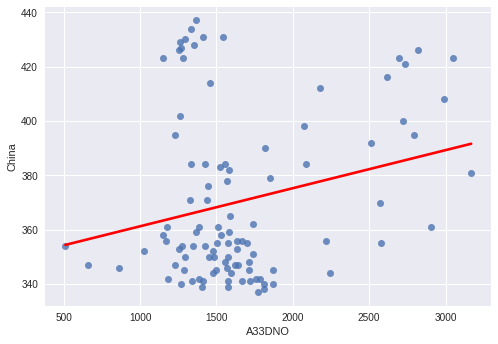

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


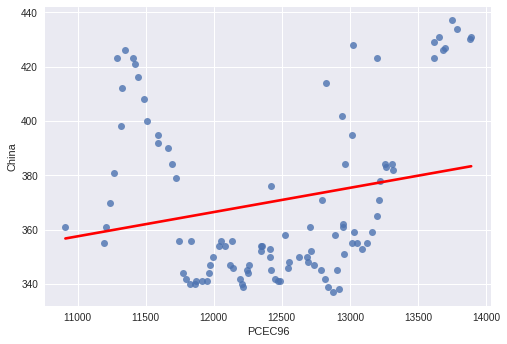

In [ ]:
for i,j in combined_data[commodity_vars].iteritems():
    sns.regplot(j, targets.iloc[:, 2], ci=None, line_kws={"color": "red"})
    plt.show()

### Observation

From the regression plots above, we can see that there exists a positive relationship between each commodity variable and each milk price as the slope accros all the plots increases towards the right. Having established this linear relationship, we can then go ahead and use a linear regression model to futher analyse these series and obtain more concrete results given the statistics obtained.

## Ordinary least squares regression using statsmodels

In [ ]:
model_vars_usa=['MHHNGSP','PSOYBUSDM', 'IPG32411S', 'A33DNO', 'PCEC96']
ols_data_usa = combined_data[model_vars_usa]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


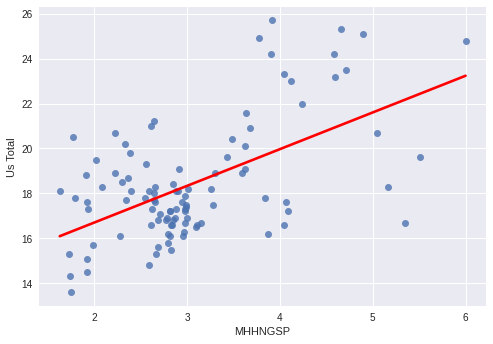

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


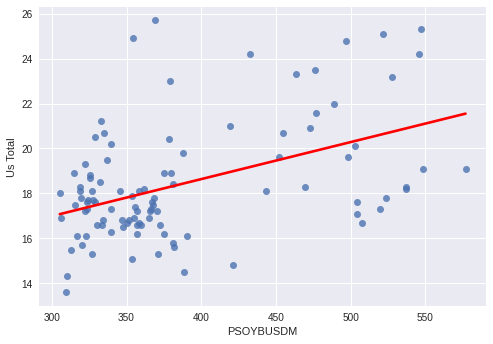

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


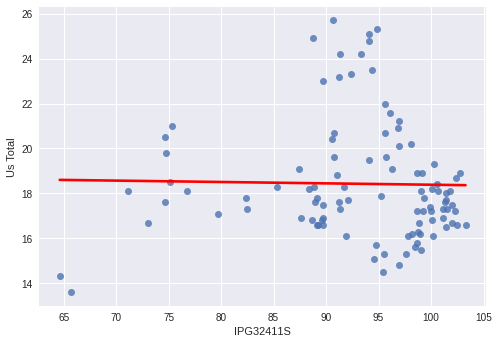

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


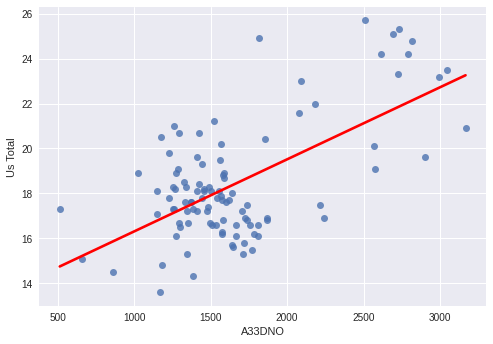

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


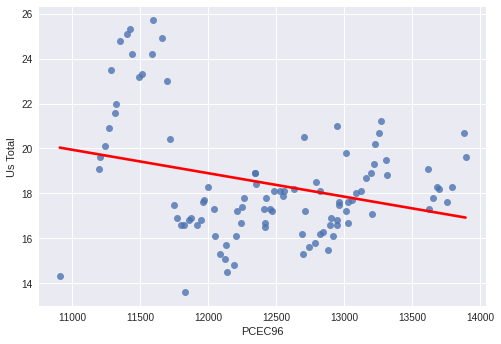

In [ ]:
for i,j in ols_data_usa.iteritems():
    sns.regplot(j, targets.iloc[:, 0],  ci=None, line_kws={"color": "red"})
    plt.show()

In [ ]:
print("=== Regression of energy variables wrt USA Milk factor === \n")
for i in model_vars_usa:
    # Fit and summarize OLS model
    const = sm.add_constant(targets.iloc[:, 0])
    mod1 = sm.OLS(ols_data_usa[i], const)
    res1 = mod1.fit()
    print(res1.summary())

=== Regression of energy variables wrt USA Milk factor === 

                            OLS Regression Results                            
Dep. Variable:                MHHNGSP   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     46.48
Date:                Thu, 28 Jul 2022   Prob (F-statistic):           7.36e-10
Time:                        10:19:29   Log-Likelihood:                -113.69
No. Observations:                 101   AIC:                             231.4
Df Residuals:                      99   BIC:                             236.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


For Germany

In [ ]:
model_vars_ger = ['PNGASEUUSDM', 'PSOYBUSDM', 'IPG32411S', 'A33DNO', 'PCEC96']
ols_data_ger = combined_data[model_vars_ger]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


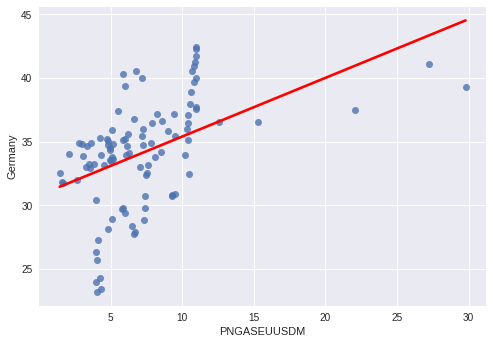

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


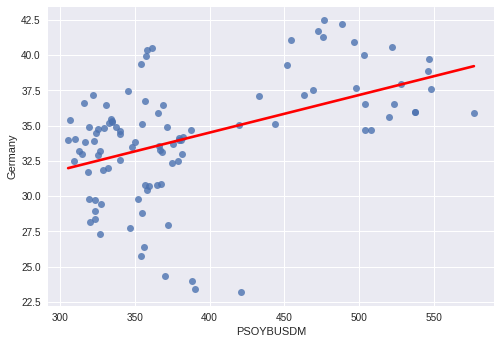

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


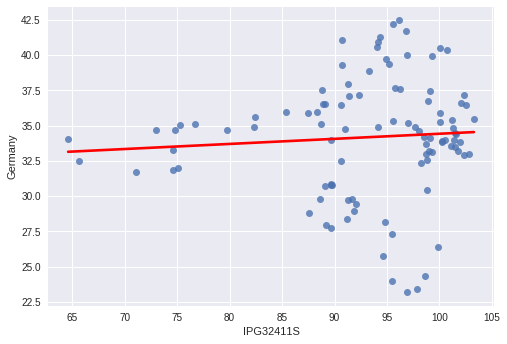

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


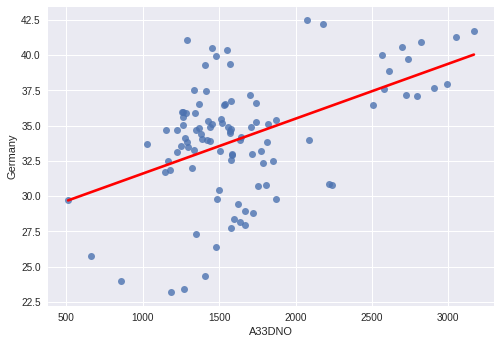

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


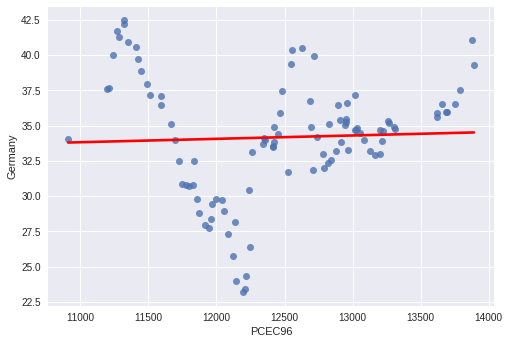

In [ ]:
for i,j in ols_data_ger.iteritems():
    sns.regplot(j, targets.iloc[:, -1],  ci=None, line_kws={"color": "red"})
    plt.show()

In [ ]:
print("=== Regression of energy wrt Ger Milk factor === \n")
for i in model_vars_ger:
    # Fit and summarize WLS model
    const = sm.add_constant(targets.iloc[:, -1])
    mod1 = sm.OLS(ols_data_ger[i], const)
    res1 = mod1.fit()
    print(res1.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


=== Regression of energy wrt Ger Milk factor === 

                            OLS Regression Results                            
Dep. Variable:            PNGASEUUSDM   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     29.96
Date:                Thu, 28 Jul 2022   Prob (F-statistic):           3.34e-07
Time:                        10:19:30   Log-Likelihood:                -279.27
No. Observations:                 101   AIC:                             562.5
Df Residuals:                      99   BIC:                             567.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

For China

In [ ]:
model_vars_ch = model_vars_ger # we use the same indicators for germany and china
ols_data_ch = combined_data[model_vars_ch]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


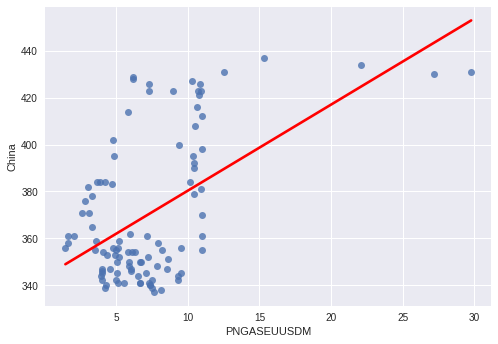

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


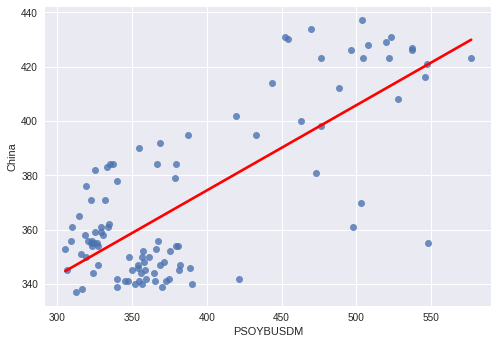

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


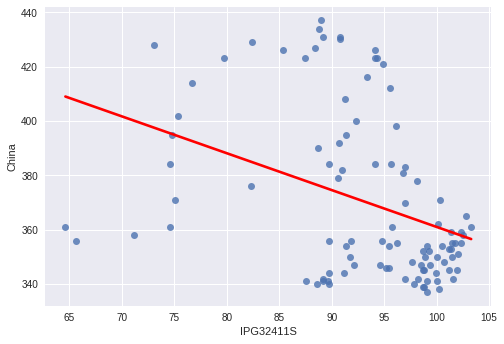

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


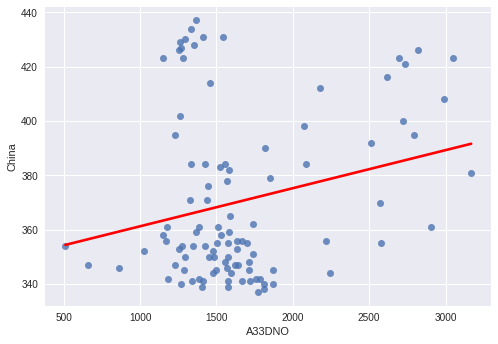

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


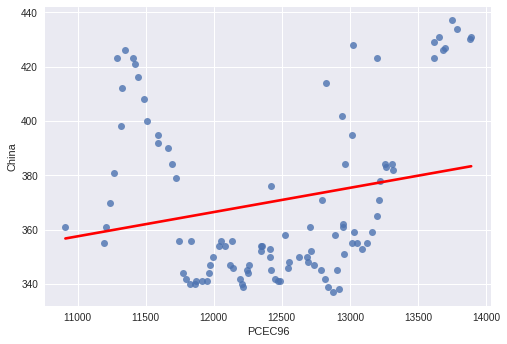

In [ ]:
for i,j in ols_data_ch.iteritems():
    sns.regplot(j, targets.iloc[:, 2],  ci=None, line_kws={"color": "red"})
    plt.show()

In [ ]:
print("=== Regression of energy variables wrt China Milk === \n")
for i in model_vars_ch:
    # Fit and summarize OLS model
    const = sm.add_constant(targets.iloc[:, 2])
    mod1 = sm.OLS(ols_data_ch[i], const)
    res1 = mod1.fit()
    print(res1.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


=== Regression of energy variables wrt China Milk === 

                            OLS Regression Results                            
Dep. Variable:            PNGASEUUSDM   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     38.76
Date:                Thu, 28 Jul 2022   Prob (F-statistic):           1.16e-08
Time:                        10:19:31   Log-Likelihood:                -275.94
No. Observations:                 101   AIC:                             555.9
Df Residuals:                      99   BIC:                             561.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------